# Invert Gill-Matsuno model using SOR method
**21 December 2020 by MiniUFO**

---
[TOC]

---

## 1. Introduction
Gill-Matsuno model ([**Matsuno 1966**](https://www.jstage.jst.go.jp/article/jmsj1965/44/1/44_1_25/_article/-char/en); [**Gill 1980**](https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.49710644905)) is a classical model studying the tropical atmospheric response to a prescribed heating source.  Inversion of the model means that we can obtain a steady-state response in terms of atmospheric flow and mass, given any kind of heating pattern.  The model on the spherical earth can be written as:
>$$
\begin{align}
-\frac{\partial\phi}{\partial x}+fv - \epsilon u &= 0 \label{Eq1}\tag{1} \\
-\frac{\partial\phi}{\partial y}-fu - \epsilon v &= 0 \label{Eq2}\tag{2} \\
\Phi \left(\frac{\partial u}{\partial x}+\frac{1}{cos\varphi}\frac{\partial vcos\varphi}{\partial y}\right)+\epsilon \phi &= -Q \label{Eq3}\tag{3}
\end{align}
$$

where $u$, $v$, and $\phi$ are the anomlous flow and mass responses relative to a reference state $U$, $V$, and $\Phi$.  Also, $U$ and $V$ are assumed to be zero (a motionless reference state).  Given the diabatic heating field $Q$, one will get the wind field ($u$, $v$) and mass field $\phi$.

## 2. Theory
Gill-Matsuno model is linear about three unknowns $u$, $v$ (horizontal flow), and $\phi$ (geopotential).  Using simple substitutions, one can obtain the explicit expressions of them as:
>$$
\begin{align}
\Phi\nabla\cdot\left(c_1\nabla\phi-c_2\hat\nabla\phi\right)-\epsilon\phi &= Q \label{Eq4}\tag{4} \\
u &= -c_1\frac{\partial \phi}{\partial x}-c_2\frac{\partial \phi}{\partial y} \label{Eq5}\tag{5} \\
v &= -c_1\frac{\partial \phi}{\partial y}+c_2\frac{\partial \phi}{\partial x} \label{Eq6}\tag{6}
\end{align}
$$

where $\nabla=(\partial_x, \partial_y)$, $\hat\nabla=(-\partial_y, \partial_x)$, $c_1=\epsilon/(\epsilon^2+f^2)$ and $c_2=f/(\epsilon^2+f^2)$.  Equation ($\ref{Eq4}$) is an elliptic equation as long as $\epsilon$, $f$, and $\Phi$ are all positive and that $\epsilon$ is not much smaller than $f$.  In component form, Eq. (4) can be written as:
>$$
\begin{align}
\Phi\frac{\partial}{\partial x}\left(c_1\frac{\partial\phi}{\partial x}+c_2\frac{\partial\phi}{\partial y}\right)+\Phi\frac{\partial}{\partial y}\left(-c_2\frac{\partial\phi}{\partial x}+c_1\frac{\partial\phi}{\partial y}\right)-\epsilon\phi&=Q\label{Eq7}\tag{7}
\end{align}
$$

One can invert $\phi$ using SOR method given $Q$, and hence the wind field $u$ and $v$ using Eqs. ($\ref{Eq5}$) and ($\ref{Eq6}$).  It can be changed slightly to fit into the general 2D solver as:
>$$
\begin{align}
\Phi c_1\frac{\partial^2\phi}{\partial y^2}+\Phi c_1\frac{\partial^2\phi}{\partial x^2}+\frac{\Phi}{r} \frac{\partial rc_1}{\partial y}\frac{\partial\phi}{\partial y}-\Phi\frac{\partial c_2}{\partial y}\frac{\partial\phi}{\partial x}-\epsilon\phi&=Q\label{Eq8}\tag{8}
\end{align}
$$

Although Eqs. (7) and (8) are equivalent, it is not clear which form is better for discretization and iteration.  Here we choose the form of Eq. (8) for SOR.

## 3. Examples
### 3.1 The classical Gill example
Gill has presented three classical atmospheric responses to different patterns of heating located at tropics in his 1980 paper.  Here we recover his results using the SOR iteration.  First, we load in data from a file with a lat/lon grid and specify the three types of heating:

In [1]:
import sys
sys.path.append('../../')
import numpy as np
import xarray as xr
from xgrads.xgrads import open_CtlDataset


lon = xr.DataArray(np.linspace(0, 360, 144), dims='lon',
                   coords={'lon':np.linspace(0, 360, 144)})
lat = xr.DataArray(np.linspace(-90, 90, 73), dims='lat',
                   coords={'lat':np.linspace(-90, 90, 73)})

lat, lon = xr.broadcast(lat, lon)

# three patterns of heating
Q1 = 0.05*np.exp(-((lat-0)**2+(lon-120)**2)/100.0)
Q2 = 0.05*np.exp(-((lat-10)**2+(lon-120)**2)/100.0) \
   - 0.05*np.exp(-((lat+10)**2+(lon-120)**2)/100.0)
Q3 = 0.05*np.exp(-((lat-10)**2+(lon-120)**2)/100.0)

Inverting the atmospheric responses in terms of mass `h` and wind field (`u`, `v`), within lat/lon plane, is as simple as:

In [6]:
from xinvert.xinvert import invert_GillMatsuno, cal_flow

iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 600,
    'tolerance': 1e-5,
    'optArg'   : 1.4,
}

mParams = {
    'epsilon': 1e-5,
    'Phi'    : 5000,
}

h1 = invert_GillMatsuno(Q1, dims=['lat','lon'], mParams=mParams, iParams=iParams)
h2 = invert_GillMatsuno(Q2, dims=['lat','lon'], mParams=mParams, iParams=iParams)
h3 = invert_GillMatsuno(Q3, dims=['lat','lon'], mParams=mParams, iParams=iParams)

u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams, vtype='GillMatsuno')
u2, v2 = cal_flow(h2, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams, vtype='GillMatsuno')
u3, v3 = cal_flow(h3, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams, vtype='GillMatsuno')

{} loops  600 and tolerance is 5.608964e-05
{} loops   87 and tolerance is 4.905623e-06
{} loops  600 and tolerance is 5.174635e-05


Notice that this is a global case, in contrast to the original $\beta$-plane case.  The result can be visualized as:

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


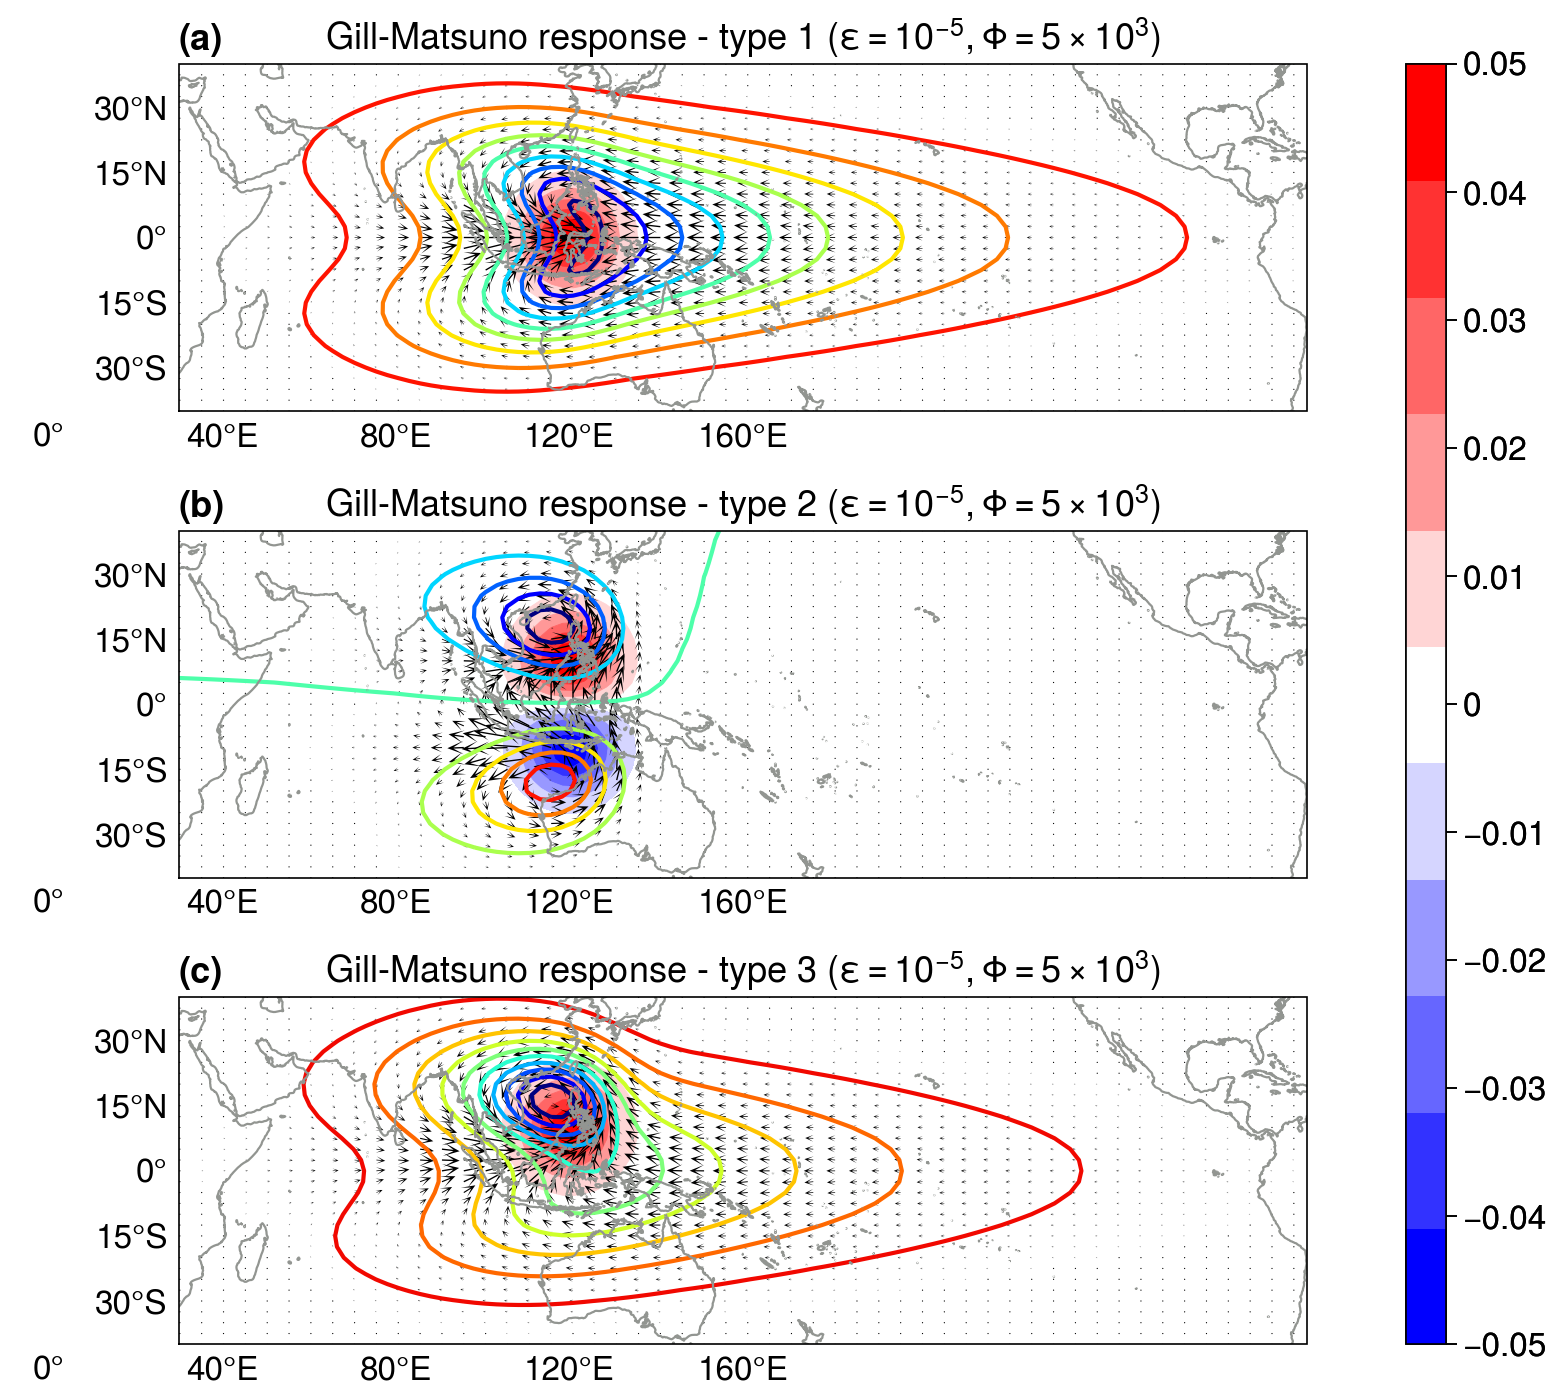

In [7]:
#%% plot wind and streamfunction
import proplot as pplt
import xarray as xr
import numpy as np
from utils.PlotUtils import maskout_cmap


lat, lon = xr.broadcast(u1.lat, u1.lon)

fig, axes = pplt.subplots(nrows=3, ncols=1, figsize=(7.8, 7), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

skip = 1
fontsize = 13

axes.format(abc='(a)', coast=True,
            lonlines=40, latlines=15, lonlabels='b', latlabels='l',
            grid=False, labels=False)

cmap = maskout_cmap('bwr', [-0.05, -0.04, -0.03, -0.02, -0.01,  0.,
                     0.01,  0.02,  0.03,  0.04,  0.05], [-0.01, 0.01])

ax = axes[0]
ax.contourf(Q1, cmap=cmap, levels=np.linspace(-0.05, 0.05, 12))
ax.contour(h1, cmap='jet')
ax.set_title('Gill-Matsuno response - type 1 ($\epsilon=10^{-5}, \Phi=5\\times 10^3$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u1.values[::skip,::skip+1], v1.values[::skip,::skip+1],
              width=0.0012, headwidth=10., headlength=12., scale=250)
              # headwidth=1, headlength=3, width=0.002)
ax.set_ylim([-40, 40])
ax.set_xlim([-150, 110])

ax = axes[1]
ax.contourf(Q2, cmap=cmap, levels=np.linspace(-0.05, 0.05, 12))
ax.contour(h2, cmap='jet')
ax.set_title('Gill-Matsuno response - type 2 ($\epsilon=10^{-5}, \Phi=5\\times 10^3$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u2.values[::skip,::skip+1], v2.values[::skip,::skip+1],
              width=0.0012, headwidth=10., headlength=12., scale=250)
ax.set_ylim([-40, 40])
ax.set_xlim([-150, 110])

ax = axes[2]
p=ax.contourf(Q3, cmap=cmap, levels=np.linspace(-0.05, 0.05, 12))
ax.contour(h3, cmap='jet')
ax.set_title('Gill-Matsuno response - type 3 ($\epsilon=10^{-5}, \Phi=5\\times 10^3$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u3.values[::skip,::skip+1], v3.values[::skip,::skip+1],
              width=0.0012, headwidth=10., headlength=12., scale=250)
ax.set_ylim([-40, 40])
ax.set_xlim([-150, 110])

fig.colorbar(p, loc='r', label='', rows=(1,3), ticks=0.01)

### 3.2 A realistic case
In this case, heating pattern is derived from the 30-60-day bandpass filtered OLR anomaly.  We just want to see if the atmospheric response based on Gill-Matsuno model is close to the observed one.  Read in data from a data file:

In [8]:
import numpy as np
import xarray as xr

ds = xr.open_dataset('../Data/MJO.nc')

# observed h and u,v anomalies (30-60day filtered)
h_ob = ds.hl
u_ob = ds.ul
v_ob = ds.vl

# observed heating anomaly (30-60day filtered)
Q = (ds.ol*-0.0015).where(np.abs(ds.lat)<60, 0)

Inversion is simple as:

In [10]:
iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 800,
    'tolerance': 1e-5,
    'optArg'   : 1.4,
}

mParams1 = {'epsilon': 1e-5, 'Phi': 5000}
mParams2 = {'epsilon': 7e-6, 'Phi': 8000}
mParams3 = {'epsilon': 7e-6, 'Phi': 10000}

h1 = invert_GillMatsuno(Q, dims=['lat','lon'], mParams=mParams1, iParams=iParams)
h2 = invert_GillMatsuno(Q, dims=['lat','lon'], mParams=mParams2, iParams=iParams)
h3 = invert_GillMatsuno(Q, dims=['lat','lon'], mParams=mParams3, iParams=iParams)

u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams1, vtype='GillMatsuno')
u2, v2 = cal_flow(h2, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams2, vtype='GillMatsuno')
u3, v3 = cal_flow(h3, dims=['lat','lon'], BCs=['fixed','periodic'], mParams=mParams3, vtype='GillMatsuno')

{} loops  355 and tolerance is 9.994105e-06
{} loops  387 and tolerance is 9.715737e-06
{} loops  412 and tolerance is 9.790870e-06


Plot the results and compare them with the observed fields:

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


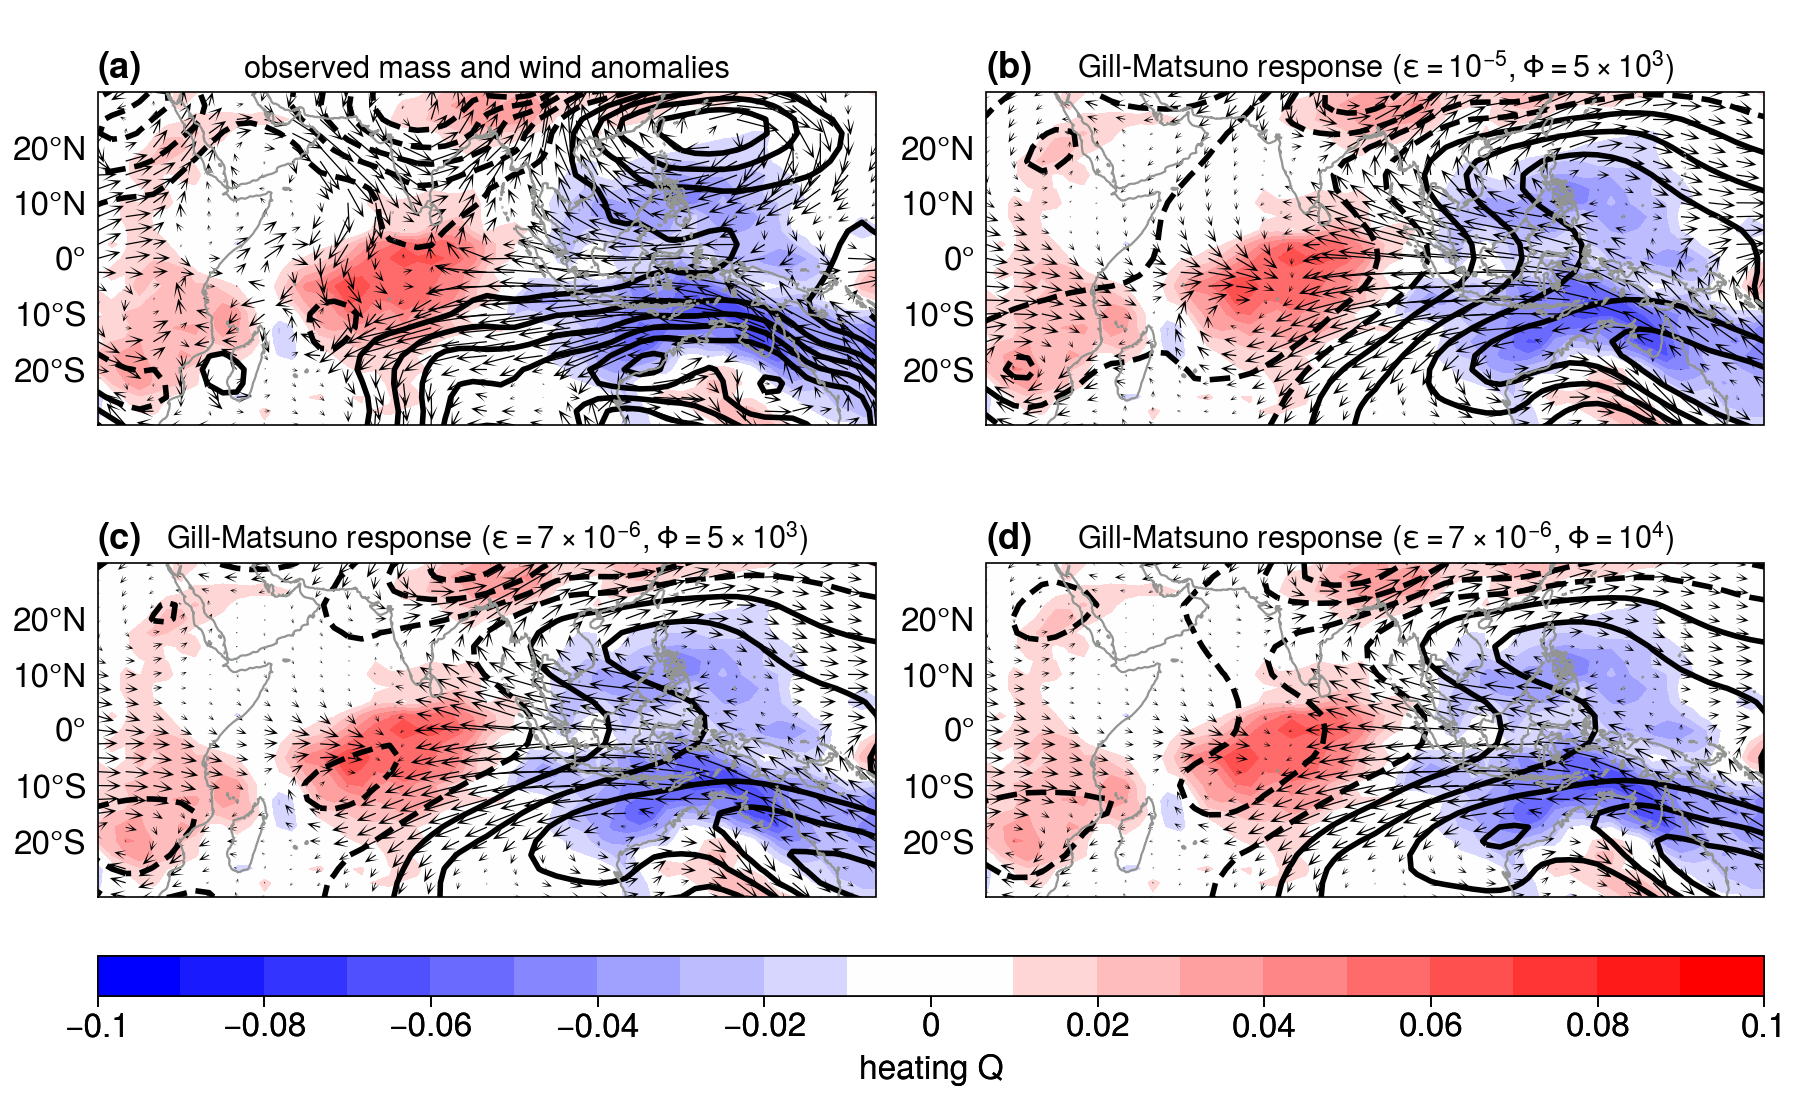

In [11]:
lat, lon = xr.broadcast(ds.lat, ds.lon)

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(9, 5.5), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

skip = 1
fontsize = 11

axes.format(abc='(a)', coast=True, grid=False, labels=False,
            lonlines=20, latlines=10, lonlabels='b', latlabels='l')

cmap = maskout_cmap('bwr', [-0.1, -0.09, -0.08, -0.07, -0.06, -0.05,
                            -0.04, -0.03, -0.02, -0.01,  0., 0.01, 0.02,
                            0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
                    [-0.01, 0.01])

ax = axes[0,0]
ax.contourf(Q, cmap=cmap, levels=np.linspace(-0.1, 0.1, 21))
ax.contour(h_ob, color='black', linewidth=2,
           levels=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
ax.set_title('observed mass and wind anomalies', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u_ob.values[::skip,::skip+1]*5, v_ob.values[::skip,::skip+1]*5,
              width=0.0016, headwidth=10., headlength=12., scale=300)
              # headwidth=1, headlength=3, width=0.002)
ax.set_ylim([-30, 30])
ax.set_xlim([-160, -20])

ax = axes[0,1]
ax.contourf(Q, cmap=cmap, levels=np.linspace(-0.1, 0.1, 21))
ax.contour(h1, color='black', linewidth=2, levels=11)
ax.set_title('Gill-Matsuno response ($\epsilon=10^{-5}, \Phi=5\\times 10^3$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u1.values[::skip,::skip+1], v1.values[::skip,::skip+1],
              width=0.0016, headwidth=10., headlength=12., scale=300)
              # headwidth=1, headlength=3, width=0.002)
ax.set_ylim([-30, 30])
ax.set_xlim([-160, -20])

ax = axes[1,0]
ax.contourf(Q, cmap=cmap, levels=np.linspace(-0.1, 0.1, 21))
ax.contour(h2, color='black', linewidth=2, levels=11)
ax.set_title('Gill-Matsuno response ($\epsilon=7\\times 10^{-6}, \Phi=5\\times 10^3$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u2.values[::skip,::skip+1], v2.values[::skip,::skip+1],
              width=0.0016, headwidth=10., headlength=12., scale=300)
ax.set_ylim([-30, 30])
ax.set_xlim([-160, -20])

ax = axes[1,1]
p=ax.contourf(Q, cmap=cmap, levels=np.linspace(-0.1, 0.1, 21))
ax.contour(h3, color='black', linewidth=2, levels=11)
ax.set_title('Gill-Matsuno response ($\epsilon=7\\times 10^{-6}, \Phi=10^4$)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+1], lat.values[::skip,::skip+1],
              u3.values[::skip,::skip+1], v3.values[::skip,::skip+1],
              width=0.0016, headwidth=10., headlength=12., scale=300)
ax.set_ylim([-30, 30])
ax.set_xlim([-160, -20])

fig.colorbar(p, loc='b', label='heating Q', ticks=0.02, length=1)


It is clear that such simple model has reproduced much of the observed signals, albeit some displacement of the response centers.

---

### References
1. Matsuno, T., 1966: [Quasi-Geostrophic Motions in the Equatorial Area.](https://www.jstage.jst.go.jp/article/jmsj1965/44/1/44_1_25/_article) *Journal of the Meteorological Society of Japan*, **44**, 25-43.
2. Gill, A. E., 1980: [Some Simple Solutions for Heat-Induced Tropical Circulation.](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.49710644905) *Quarterly Journal of the Royal Meteorological Society*, **106**, 447-462.